# CIFAR-10 experiment 1 (09022018)

The goal of this notebook is to explore CIFAR-10 dataset, estabilish an SVM benchmark, extract features using a pre-trained ConvNet and fit and evaluate a final SVM classifier.

In [1]:
import numpy as np
from sklearn import svm

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable
print('torch version:', torch.__version__)

from torchvision.datasets import CIFAR10
from torchvision.transforms import ToPILImage, ToTensor, Compose
from torchvision.utils import make_grid
from torchvision.models import inception_v3, resnet152, vgg19

ROOT_DIR = '.'

torch version: 0.3.0.post4


## CIFAR-10 exploration

First, let us download the dataset and make an additional split of test subset into validation and proper test subsets. Proper test subset will be held out during hyperparameter search, so we could have an unbiased estimate of the accuracy of our final model.

In [2]:
cifar_train = CIFAR10(root=ROOT_DIR, download=True, train=True)
cifar_val = CIFAR10(root=ROOT_DIR, download=True, train=False)
cifar_test = CIFAR10(root=ROOT_DIR, download=True, train=False)
print(len(cifar_train), len(cifar_test))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
50000 10000


In [3]:
splitting_point = int(len(cifar_test)*0.5)
cifar_val.test_data = cifar_val.test_data[:splitting_point]
cifar_val.test_labels = cifar_val.test_labels[:splitting_point]
cifar_test.test_data = cifar_test.test_data[splitting_point:]
cifar_test.test_labels = cifar_test.test_labels[splitting_point:]
print(len(cifar_train), len(cifar_val), len(cifar_test))

50000 5000 5000


Then, let us visualize a random sample from each of ten classes of CIFAR-10 dataset. The classes included are: an airplane, an automobile, a bird, a deer, a dog, a frog, a horse, a ship, and a truck.

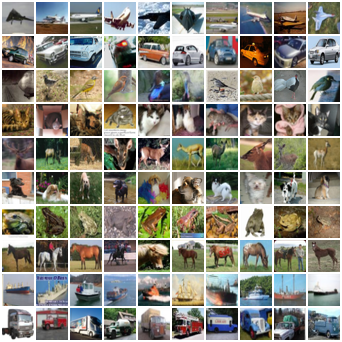

In [4]:
show = ToPILImage()
tensorize = ToTensor()

def sample(dataset_labels, class_num, sample_size=10):
    return np.random.choice(
        np.where(np.array(dataset_labels) == class_num)[0], 
        size=sample_size
    )

grid = make_grid([
    tensorize(cifar_train.train_data[idx])
    for class_num in range(10)
    for idx in sample(cifar_train.train_labels, class_num)
], pad_value=1, nrow=10)
show(grid)

# SVM baseline

Now let us estabilish a baseline. We will train an SVM model with default hyperparameters.

In [27]:
assert not np.isfortran(cifar_train.train_data)  # Make sure data are C-ordered for SVM performance
clf = svm.SVC(verbose=True)
clf.fit(
    cifar_train.train_data.reshape(-1, 32*32*3)[:5000], 
    cifar_train.train_labels[:5000]
)
clf.score(
    cifar_val.test_data.reshape(-1, 32*32*3),
    cifar_val.test_labels
)

[LibSVM]

0.1008

# Extracting image features using a pre-trained CNN

We will extract features using for downstream classification using [Inception-v3](http://arxiv.org/abs/1512.00567) network pretrained on ImageNet dataset.

In [11]:
inception_model = inception_v3(pretrained=True)

In [8]:
inception_model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d (3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d (32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d (64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d (80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True)
  )
  (Mixed_5b): InceptionA(
    (branch1x1): BasicConv2d(
      (conv): Conv2d (192, 64, kernel_si

In [15]:
new_inception = Sequential(*list(inception_model.children())[:-1])

In [17]:
class InceptionFeatureExtractor(nn.Module):
    
    def __init__(self, original_inception, **kwargs):
        super(InceptionFeatureExtractor, self).__init__(**kwargs)
        for name, module in original_inception.named_children():
            setattr(self, name, module)
        
    def forward(self, x, ):
        # 299 x 299 x 3
        x = self.Conv2d_1a_3x3(x)
        # 149 x 149 x 32
        x = self.Conv2d_2a_3x3(x)
        # 147 x 147 x 32
        x = self.Conv2d_2b_3x3(x)
        # 147 x 147 x 64
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # 73 x 73 x 64
        x = self.Conv2d_3b_1x1(x)
        # 73 x 73 x 80
        x = self.Conv2d_4a_3x3(x)
        # 71 x 71 x 192
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # 35 x 35 x 192
        x = self.Mixed_5b(x)
        # 35 x 35 x 256
        x = self.Mixed_5c(x)
        # 35 x 35 x 288
        x = self.Mixed_5d(x)
        # 35 x 35 x 288
        x = self.Mixed_6a(x)
        # 17 x 17 x 768
        x = self.Mixed_6b(x)
        # 17 x 17 x 768
        x = self.Mixed_6c(x)
        # 17 x 17 x 768
        x = self.Mixed_6d(x)
        # 17 x 17 x 768
        x = self.Mixed_6e(x)
        # 17 x 17 x 768
        x = self.Mixed_7a(x)
        # 8 x 8 x 1280
        x = self.Mixed_7b(x)
        # 8 x 8 x 2048
        x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x = x.view(x.size(0), -1)
        # 2048
        return x


In [18]:
inception_feature_extractor = InceptionFeatureExtractor(original_inception=inception_model)

In [38]:
sample = Variable(torch.FloatTensor(5, 3, 300, 300))
inception_model(sample)

(Variable containing:
  0.0971 -0.2662  0.0664  ...   0.0597  0.3361 -0.0299
 -0.3613 -0.1182 -0.2719  ...   0.1504  0.7318  0.1737
 -0.9163 -0.6128  0.0230  ...  -0.1357 -0.1920  0.7660
 -0.1098 -0.7432  0.3475  ...   0.5028 -0.4229  0.6079
  0.2348  0.0622 -0.1339  ...  -0.3683  0.5664  0.2558
 [torch.FloatTensor of size 5x1000], Variable containing:
  2.5360e-01 -4.3463e-01 -9.1128e-02  ...  -1.8099e-01 -1.7607e-01  2.5551e-01
  2.5360e-01 -4.3463e-01 -9.1128e-02  ...  -1.8099e-01 -1.7607e-01  2.5551e-01
  2.5360e-01 -4.3463e-01 -9.1128e-02  ...  -1.8099e-01 -1.7607e-01  2.5551e-01
  2.5360e-01 -4.3463e-01 -9.1128e-02  ...  -1.8099e-01 -1.7607e-01  2.5551e-01
  2.5360e-01 -4.3463e-01 -9.1128e-02  ...  -1.8099e-01 -1.7607e-01  2.5551e-01
 [torch.FloatTensor of size 5x1000])